In [1]:
import warnings

import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models import GPModel
from pyro.infer import MCMC, HMC, NUTS, Predictive

import arviz as az

In [2]:
pyro.set_rng_seed(545711891)
torch.set_default_dtype(torch.float64)

testing = True # TODO: set to False

In [3]:
# Constants
n_train = 20
n_test = 10
N = n_train + n_test
beta = 100
X = torch.linspace(0.0, 1.0, N) # grid of observations
x_axis = torch.linspace(0.0, 1.0, 101) # used for graphing

# We optimize the following parameters:
# variance, lengthscale, period, noise
params = ("kernel_var", "kernel_length", "kernel_period", "noise")

In [4]:
# We choose a periodic kernel,
# as the function we are fitting has periodic tendencies.
def kernel(X, Z, var, length, period):
    d = X.unsqueeze(1).unsqueeze(1) - Z.unsqueeze(1).unsqueeze(0)
    scaled_sin = torch.sin(torch.pi * d / period) / length
    return var * torch.exp(-2 * (scaled_sin**2).sum(-1))

In [5]:
# For the model, we keep the noise a fixed parameter,
# and make all of the other parameters (variance, lengthscale, period) variable.
class Model():
    def __init__(self):
        pass

    def __call__(self, X, y=None):
        # As we don't want any of the kernel parameters to be negative,
        # we use lognormal priors.
        var    = pyro.sample("kernel_var",    dist.LogNormal(0.0, 1.0))
        length = pyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
        period = pyro.sample("kernel_period", dist.LogNormal(0.0, 1.0))
        noise  = pyro.sample("noise",         dist.LogNormal(-5.0, 0.5))

        # Compute the covariance with the chosen kernel
        cov = kernel(
            X, X,
            var=var, length=length, period=period
        )
        cov += noise * torch.eye(X.shape[0])

        # Sample predictive values as a gaussian.
        return pyro.sample(
            "y",
            dist.MultivariateNormal(loc=torch.zeros(X.shape[0]), covariance_matrix=cov),
            obs=y,
        )

In [6]:
# Function to learn
def g(x):
    return -(torch.sin(6*torch.pi*x))**2 + 6*x**2 - 5*x**4 + 3.0/2.0 

In [7]:
def sample_data(X, n_train, n_test):
    N = n_train + n_test
    # Partition sample points
    idx = np.random.permutation(N)
    X = X[idx]
    # Sample y_i = g(x_i) + ϵ
    noise = dist.Normal(0.0, beta**-1).sample(sample_shape=(N,))
    y = g(X) + noise
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [8]:
def predict(X, y, X_pred, var, length, period, noise):
    N = X.shape[0]
    eta = (var, length, period)
    # Follow simple GP algorithm from p. 40
    # of Oswin's notes.
    K_S =  kernel(X, X, *eta)
    K_Sx = kernel(X, X_pred, *eta)
    K_xx = kernel(X_pred, X_pred, *eta)
    G = torch.linalg.inv(noise * torch.eye(N) + K_S)
    a = torch.matmul(G, y)
    mustar = torch.matmul(K_Sx.T, a)
    Sigmastar = K_xx - torch.matmul(torch.matmul(K_Sx.T, G), K_Sx)
    return mustar, Sigmastar # return mean and covariance matrix

In [9]:
def plot_data(ax, X_train, y_train, X_test, y_test, plot_g=True):
    ax.plot(X_train, y_train, 'kx', label='train')
    ax.plot(X_test, y_test, 'k.', label='test')
    if plot_g:
        ax.plot(x_axis, g(x_axis), 'r-', label='g(x)')
    ax.legend()

In [10]:
def plot_prior_samples(ax, samples):
    N = len(x_axis)
    ax.plot(x_axis, samples.T, lw=2)

In [11]:
def plot_gaussian(ax, X, mean, cov, mean_label=None, sd_label=None):
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt().detach().numpy()
    ax.plot(X, mean, "g", lw=2, label=mean_label)  # plot the mean
    ax.fill_between(
        X,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd),
        (mean + 2.0 * sd),
        color="C0",
        alpha=0.3,
        label=sd_label,
    )

In [12]:
def plot_predictions(ax, X_train, y_train, X_test, y_test, X, mean, cov):
    plot_data(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        plot_g=False,
    )
    plot_gaussian(
        ax=ax,
        X=X,
        mean=mean,
        cov=cov,
        mean_label="GP prediction",
        sd_label="GP uncertainty",
    )

In [13]:
def plot_loss(ax, loss):
    ax.plot(loss)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

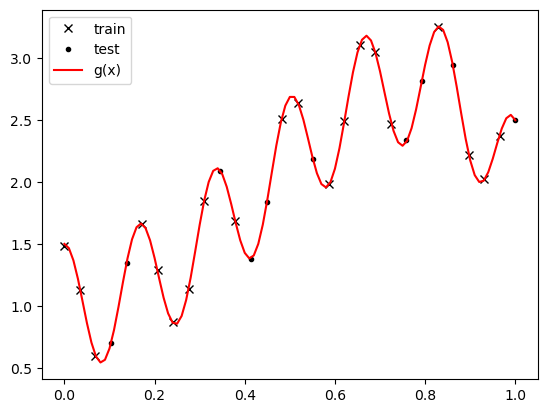

In [14]:
# Sample and plot the data
X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)
fig, ax = plt.subplots()
plot_data(ax, X_train, y_train, X_test, y_test)

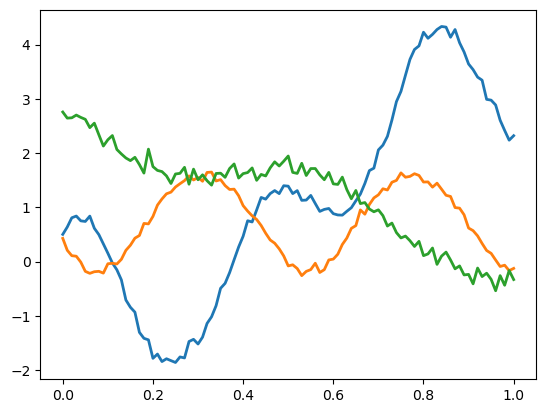

In [15]:
# Samples of unlearned GP
model = Model()
samples = np.array([model(x_axis).detach().numpy() for _ in range(3)])
fig, ax = plt.subplots()
plot_prior_samples(ax, samples)

# Training via variational inference

In [16]:
def train_vi(model, X_train, y_train, num_steps):
    pyro.clear_param_store()
    
    # Compute MAP estimate via gradient descent.
    guide=pyro.infer.autoguide.AutoDelta(model)
    optim=pyro.optim.Adam({"lr": 0.01})
    svi=pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

    losses = []
    for i in range(num_steps):
        print(f"Training step {i+1}/{num_steps}", end="\r")
        loss = svi.step(X_train, y_train)
        losses.append(loss)
    print()

    # Extract learned parameters
    learned_params = [pyro.get_param_store()["AutoDelta." + param] for param in params]

    return learned_params, losses

In [17]:
num_steps = 2000 if not testing else 100

model = Model()
learned_params, losses = train_vi(model, X_train, y_train, num_steps)

Training step 100/100


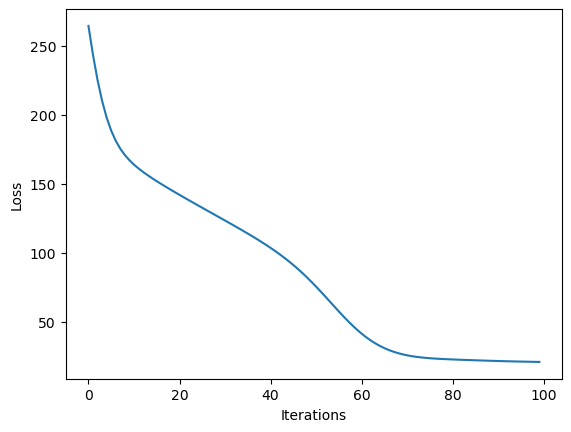

In [18]:
# Plot losses
fig, ax = plt.subplots()
plot_loss(ax, losses)

X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])


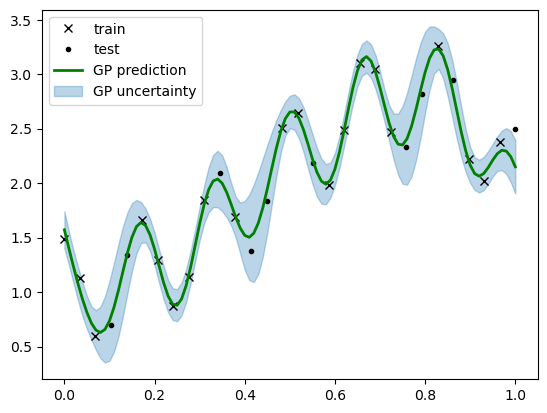

In [19]:
# Plot prediction
mean_pred, cov_pred = predict(X_train, y_train, x_axis, *learned_params)

fig, ax = plt.subplots()
plot_predictions(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    X=x_axis, mean=mean_pred, cov=cov_pred,
)
ax.legend()

In [20]:
# Calculate the log-likelihood of the predictions on the test data
mean_pred, cov_pred = predict(X_train, y_train, X_test, *learned_params)
log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: 5.817267699997089


# Training via MCMC with NUTS

In [21]:
def train_nuts(model, X_train, y_train, warmup_steps, num_samples, num_chains):
    pyro.clear_param_store()
    idata = None

    # sequentially run chains, since backend mp_context is not working as expected. Parallel running broken for notebooks.
    for _i in range(num_chains):
        nuts_kernel = NUTS(
            model=model,
            adapt_step_size=True,
            jit_compile=True
        )
        mcmc = MCMC(
            nuts_kernel,
            num_samples=warmup_steps,
            warmup_steps=num_samples,
            num_chains=1,
        )
        mcmc.run(X_train, y_train)
        if idata == None:
            idata = az.from_pyro(mcmc)
        else:
            idata_i = az.from_pyro(mcmc)
            idata = az.concat(idata, idata_i, dim="chain")

    # Extract posterior parameters
    posterior_params = [torch.tensor(idata.posterior[param].data).flatten() for param in params]

    return posterior_params, idata

In [22]:
# Hyper-parameters for learning
warmup_steps = 1000 if not testing else 10
num_samples = 1000 if not testing else 10
num_chains = 5 if not testing else 3

model = Model()
posterior_params, idata = train_nuts(model, X_train, y_train, warmup_steps, num_samples, num_chains)

Sample: 100%|████████████████████████████████████████████| 20/20 [00:03,  5.49it/s, step size=1.45e-01, acc. prob=0.706]                                                                                             
/usr/lib/python3.13/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
Sample: 100%|████████████████████████████████████████████| 20/20 [00:06,  3.05it/s, step size=7.95e-02, acc. prob=0.964]                                                                                             
/usr/lib/python3.13/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
Sample: 100%|████████████████████████████████████████████| 20/20 [00:05,  3.88it/s, step size=9.79e-02, acc. prob=0.929]            

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
kernel_length  1.718  0.665   0.787    3.561      0.153    0.112      17.0   
kernel_period  1.760  0.592   1.120    2.939      0.158    0.114      17.0   
kernel_var     1.853  0.957   0.736    3.574      0.179    0.128      23.0   
noise          0.078  0.020   0.053    0.115      0.003    0.003      35.0   

               ess_tail  r_hat  
kernel_length      15.0   1.21  
kernel_period      36.0   1.18  
kernel_var         36.0   1.15  
noise              21.0   1.44  


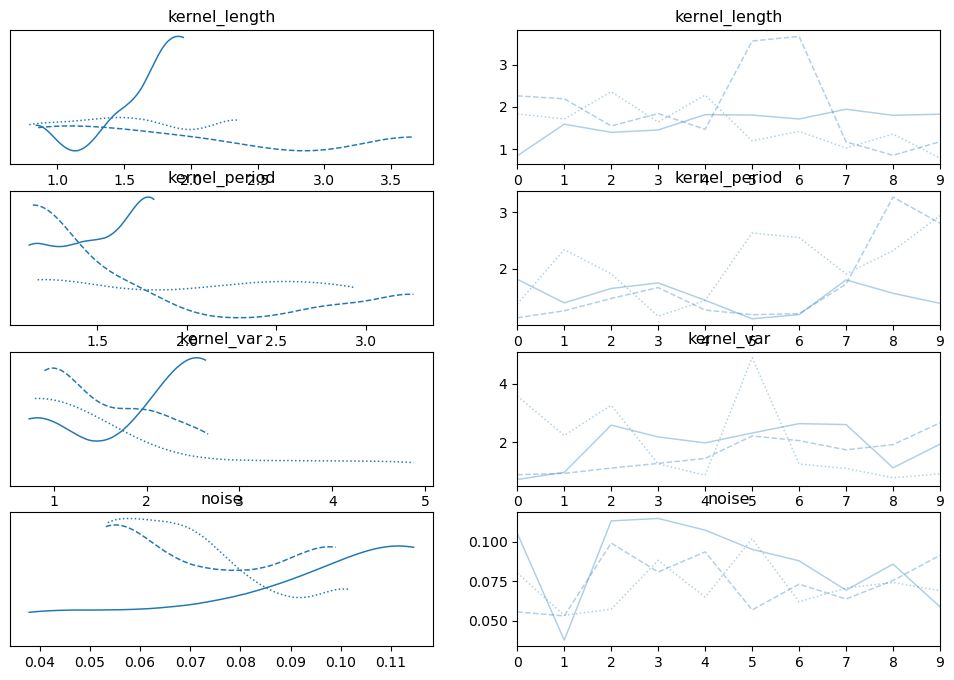

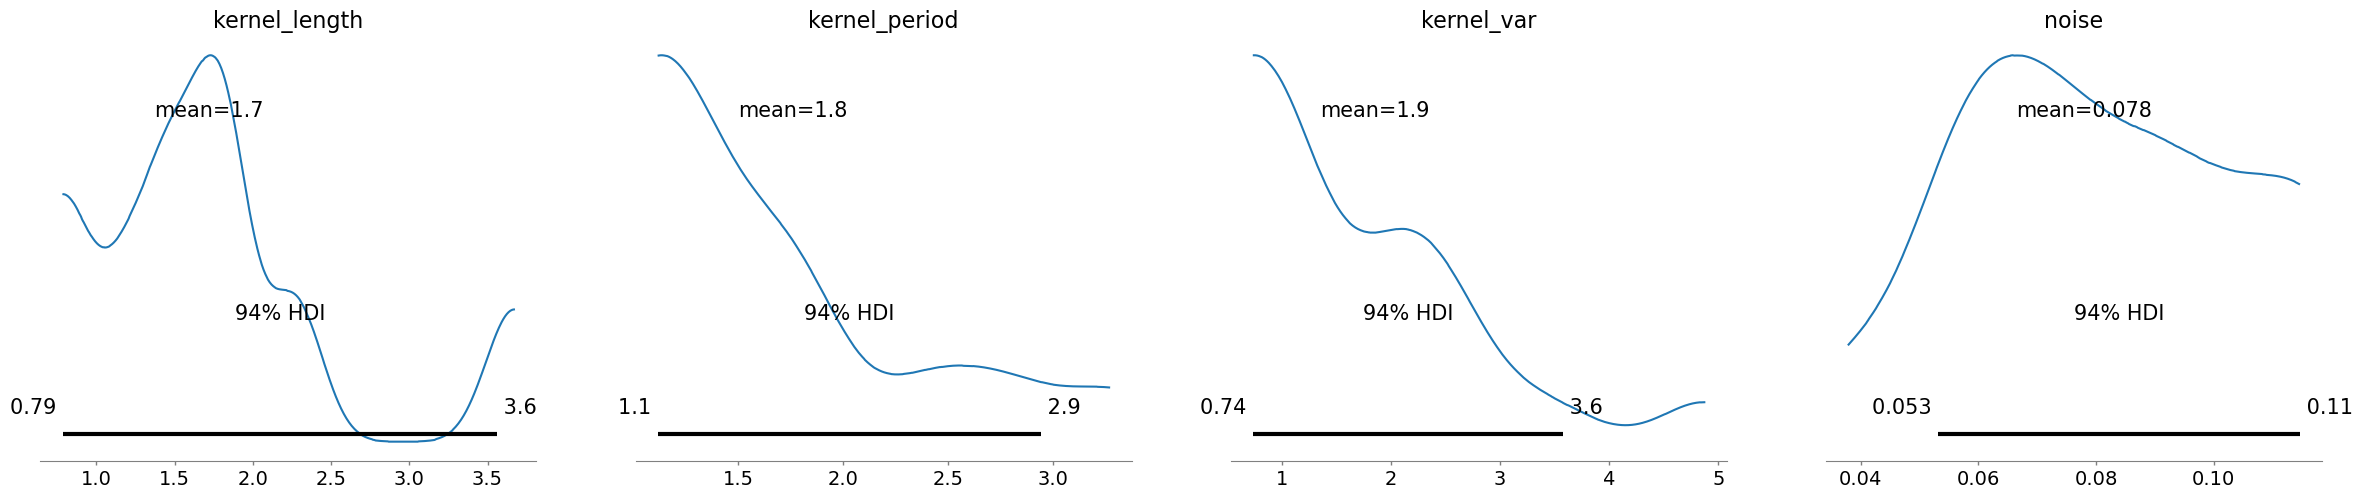

In [23]:
# inspect the sampled data
summary = az.summary(idata)
print(summary)
az.plot_trace(idata)
plt.show()
az.plot_posterior(idata)
plt.show()

X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])
X.shape    = torch.Size([101])
mean.shape = torch.Size([101])
cov.shape  = torch.Size([101, 101])


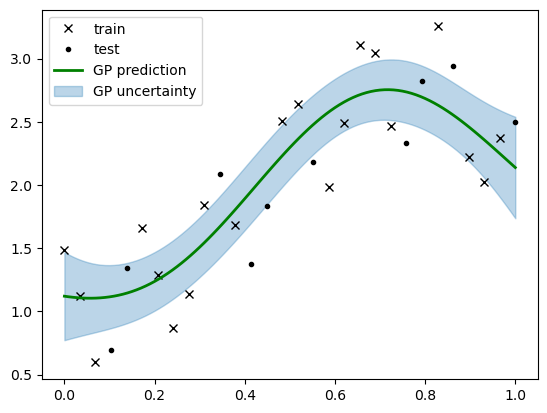

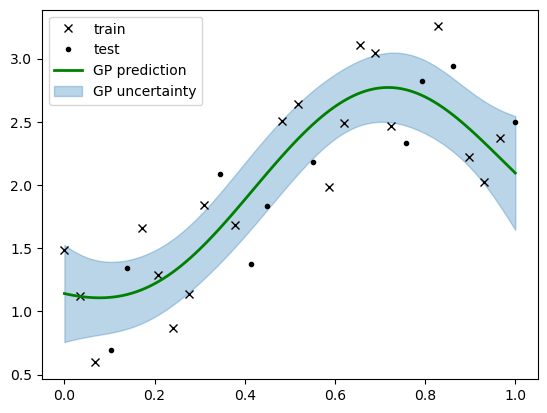

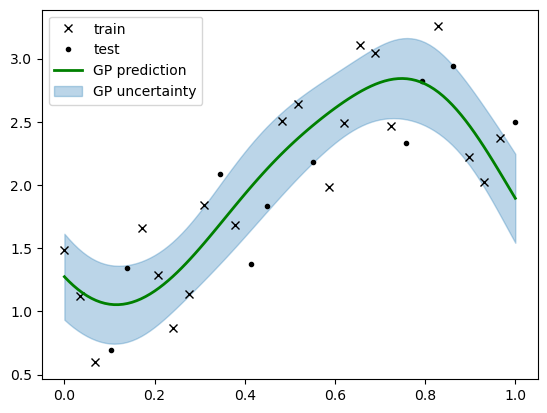

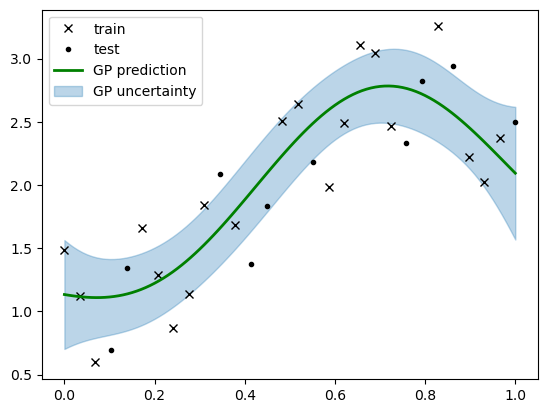

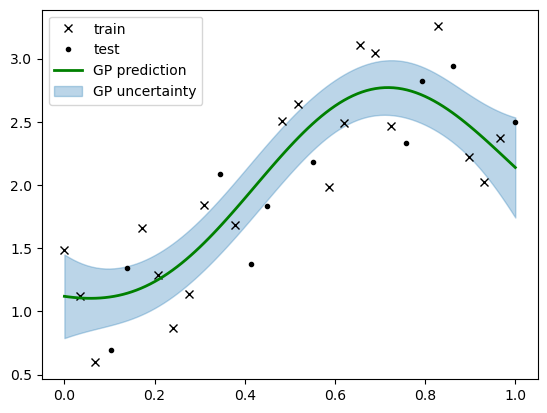

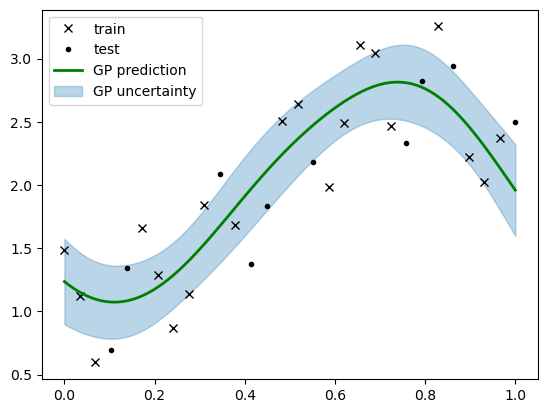

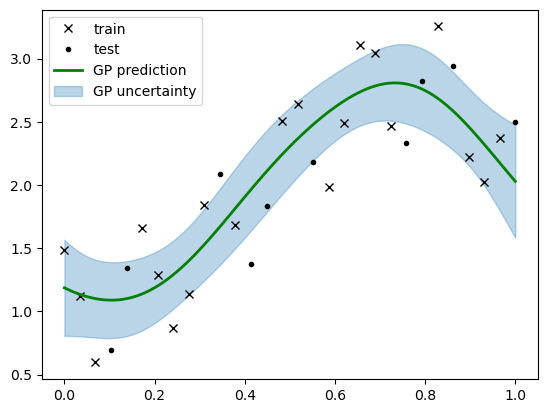

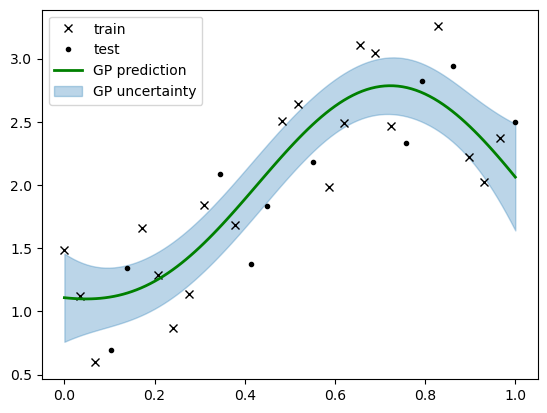

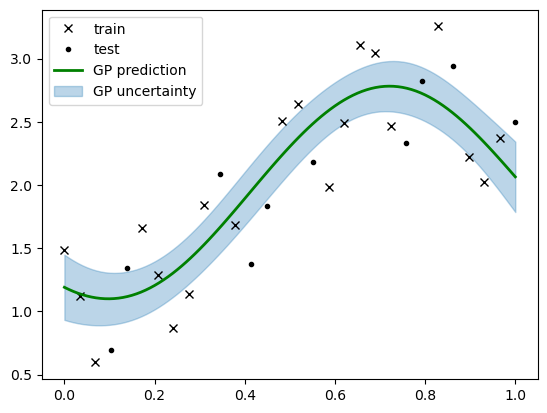

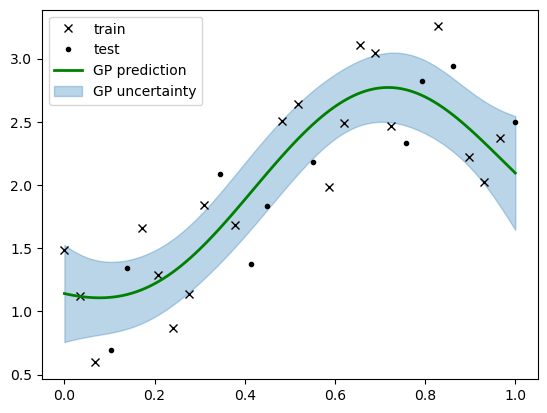

In [24]:
# plot 10 predictions over the x axis
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period, noise: predict(
        X_train, y_train, x_axis, var, length, period, noise
    )
)(*posterior_params)

idx = torch.randint(num_samples*num_chains, size=(10,))
for i in range(10):
    j = idx[i]
    fig, ax = plt.subplots()
    plot_predictions(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        X=x_axis, mean=mean_preds[j], cov=cov_preds[j],
    )
    ax.legend()

In [25]:
# Calculate the log-likelihood of the average
# of the sampled predictions on the test data
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period, noise: predict(
        X_train, y_train, X_test, var, length, period, noise
    )
)(*posterior_params)

mean_pred = torch.mean(mean_preds, axis=0)
cov_pred = torch.mean(cov_preds, axis=0)

log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: -53758.65842288956


# Learning with integral constraints

Compute the mean and covariance of the distribution
$f|X,\hat{q}$.

In [26]:
def cond_prob_dist(X, q, kernel_params):
    l = len(X)
    # Weight vector
    w = torch.tensor(
        [1.0/(2*l-2) if i == 0 or i == l-1 else 1.0/(l-1) for i in range(l)]
    ).reshape((1,l))
    # Stack `w` on top of identity matrix
    Q = torch.vstack((w, torch.eye(l)))
    # Kernel matrix
    K = kernel(X, X, *kernel_params)

    # Covariance of (q, f)|f
    S = Q @ K @ Q.T
    # Split into four blocks
    S11 = S[0,0].reshape((1,1))
    S12 = S[0,1:].reshape((1,l))
    S21 = S[1:,0].reshape((l,1))
    S22 = S[1:,1:].reshape((l,l))
    # Compute mean(s) and covariance
    mean = S21 @ torch.linalg.inv(S11) * q
    cov = S22 - S21 @ torch.linalg.inv(S11) @ S21.T

    return mean, cov

In [27]:
# We train a fresh model
model = Model()
learned_params, _ = train_vi(model, X_train, y_train, num_steps)
kernel_params, noise = learned_params[:-1], learned_params[-1]

Training step 100/100


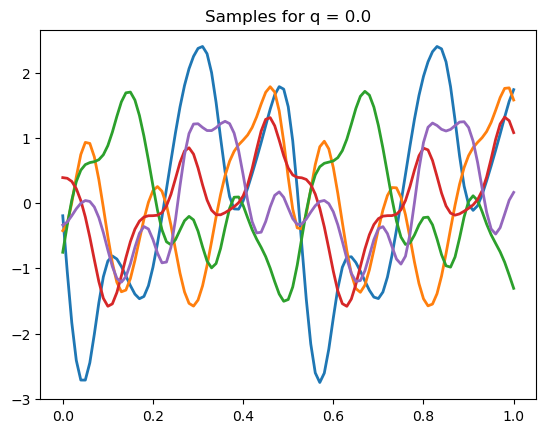

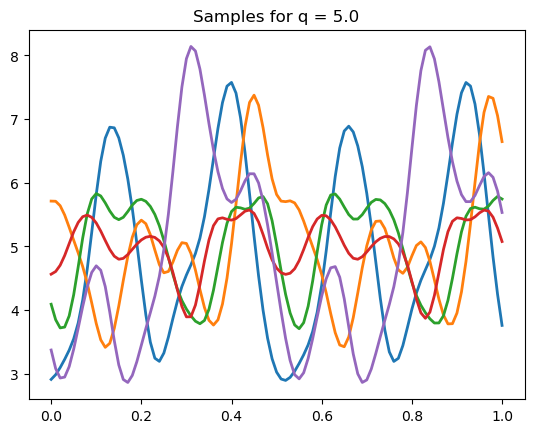

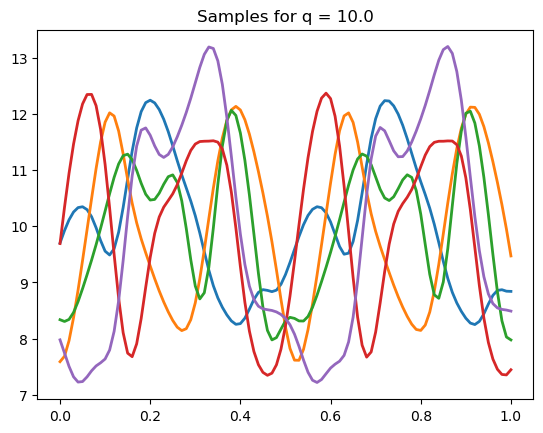

In [32]:
l = 101
X = torch.linspace(0.0, 1.0, l)
qs = torch.tensor([0.0,5,10])
# for each value of `q`, plot five samples.
for q in qs:
    mean, cov = cond_prob_dist(X, q, kernel_params)
    y = scipy.stats.multivariate_normal(
        mean.detach().numpy().flatten(),
        cov.detach().numpy(),
        allow_singular=True,
    ).rvs(size=5)
    fig, ax = plt.subplots()
    plot_prior_samples(ax, y)
    ax.set_title(f"Samples for q = {q}")